# Srujan Jabbireddy - Homework 4

**Due Monday 13th April at 11:55pm**

In the first part of this homework you will compute the posterior distribution for a Poisson likelihood with a gamma prior using:
* Model Conjugacy
* Numerical Integration
* Metropolis Hastings Algorithm

All of these methods should give the same answer (up to numerical approximation). 

In practice, one would use the conjugate model result to derive the posterior because this method is computationally fastest. 

However the  methods of numerical integration and Metropolis Hastings are more general in that they could be used on other, non-conjugate models. 

Metropolis Hastings is particularly useful because it can be used for problems where the parameter dimension is too high for direct numerical integration. 

**Optional extra credit (Problem 4):** implement Stan for 8 schools example. 

## Problem 1

Suppose we observe $$X_1,\ldots,X_n \sim \text{Pois}(\lambda)$$ where $\text{Pois}(\lambda)$ denotes a Poisson distribution with mean parameter $\lambda$. 

Specifically
$$ P(X=x|\lambda)  = \frac{\lambda^x e^{-\lambda}}{x!}$$
for $x=0,1,\dots$. We put a $Gamma(\alpha,\beta)$ prior on $\lambda$, which we denote by $\pi(\lambda)$. This prior has the form
$\pi(\lambda) = \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha-1} e^{-\beta\lambda}$
for $\lambda > 0$. 

Recall that $\alpha, \beta > 0$ are fixed, known constants.

1. Using a few lines of algebra determine the posterior distribution.
2. Plot the Gamma prior probability density with $\alpha=3$, $\beta=1/2$ and plot the corresponding posterior density assuming $n=10$ and 
 $(x_1,\dots,x_n) = (4,5,1,3,3,1,4,5,0,5)$



Note: In python,`np.random.gamma` and `scipy.stats.gamma` use the scale parameterization. We use the rate parameterization: rate = 1/scale. R has options for both rate and scale parameterization in `rgamma`, `dgamma`, etc. See [here](https://en.wikipedia.org/wiki/Exponential_distribution) and [here](https://en.wikipedia.org/wiki/Gamma_distribution) for some discussion of different parameterizations.

Q1.1

$$ P(X=x|\lambda)  = \frac{\lambda^x e^{-\lambda}}{x!}$$
The Likelihood is:
$$ L(\lambda|x)  = \frac{\lambda^{\sum_i x_i} e^{-n\lambda}}{\prod_i x_i!}$$
Prior is:
$$\pi(\lambda) = \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha-1} e^{-\beta\lambda}$$

Hence, the posterior is likelihood times prior:

$$\pi(\lambda|x) \propto f(x|\lambda)\pi(\lambda)$$

$$\pi(\lambda|x) \propto \lambda^{\sum_i x_i+\alpha-1} e^{-(n+\beta)\lambda}$$

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
x = np.array([4,5,1,3,3,1,4,5,0,5])
n = np.size(x)
np.mean(x)

3.1

In [3]:
## prior parameters
prior_alpha = 3
prior_beta = 0.5

In [4]:
## posterior parameters
post_alpha = prior_alpha + np.sum(x)
post_beta =  prior_beta + n

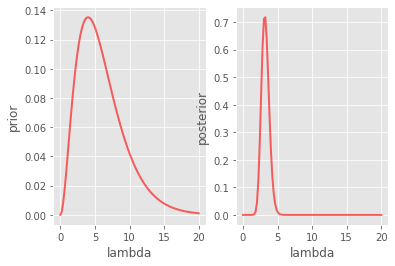

In [7]:
fig = plt.figure()
#fig.subplots_adjust(hspace=0.50, wspace=1)

lmbda = np.linspace(0,20,100)

### plot the prior
ax = fig.add_subplot(1, 2, 1)
ax.plot(lmbda, scipy.stats.gamma.pdf(lmbda,a=prior_alpha,scale=1/prior_beta),
         'r-', lw=2, alpha=0.6, label='gamma prior')
ax.set(xlabel='lambda', ylabel='prior');


### plot the posterior
ax = fig.add_subplot(1, 2, 2)
ax.plot(lmbda, scipy.stats.gamma.pdf(lmbda,a=post_alpha,scale=1/post_beta),
         'r-', lw=2, alpha=0.6, label='gamma posterior')
ax.set(xlabel='lambda', ylabel='posterior');

## Problem 2

Recall that the posterior is proportional to the likelihood times the prior
$$ \pi(\lambda|x) \propto f(x|\lambda)\pi(\lambda)$$

Here $x=(x_1,\ldots,x_n)$ and $f(x|\lambda) = \lambda^{\sum_i x_i} e^{-n\lambda}/(\prod_i x_i!)$ is the joint probability density function, i.e., the likelihood when viewed as a function of $\lambda$. 

Plot $f(x|\lambda)\pi(\lambda)$ (or something proportional to it) for the $Gamma(\alpha=3,\beta=1/2)$ prior and data from the previous question. Numerically integrate this function and use the result to normalize $f(x|\lambda)\pi(\lambda)$. 

Verify that the result matches the posterior you found in Problem 1.

In [33]:
def posterior(lbda):
    return scipy.stats.gamma.pdf(lbda,a=prior_alpha,scale=1/prior_beta)*np.power(lbda,np.sum(x))*np.exp(-lbda*n)

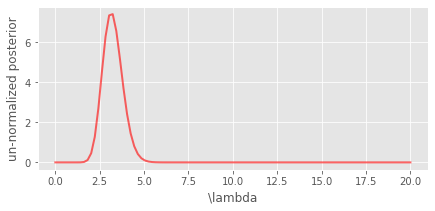

In [40]:
fig = plt.figure()
#fig.subplots_adjust(hspace=0.4, wspace=.25)

lbda = np.linspace(0,20,100)

### plot the prior
ax = plt.axes()
ax.plot(lmbda, posterior(lmbda),'r-', lw=2, alpha=0.6, label='posterior')
ax.set(xlabel='\lambda', ylabel='un-normalized posterior');

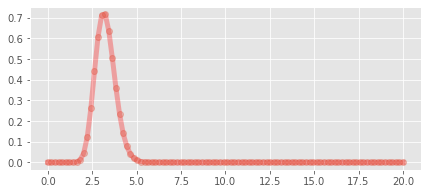

In [39]:
import scipy.integrate as integrate
mx = integrate.quad(lambda lmbda: posterior(lmbda), 0, 20)

## get plot sizes reasonable
plt.rcParams['figure.figsize'] = (7, 3)
ax = plt.axes()
### plot the posterior using conjugacy result
ax.plot(lmbda, scipy.stats.gamma.pdf(lmbda,a=post_alpha,scale=1/post_beta),'r-', lw=5, alpha=0.3)
ax.plot(lmbda, posterior(lmbda)/mx[0],'o', lw=2, alpha=0.3);

#### The numerically approximated and conjugate posterior match very well.

## Problem 3

Write (or adapt code from class) a Metropolis Hastings algorithm to sample from the posterior. 

Draw a histogram of the samples and verify that they approximately match the posterior determined using conjugacy or numerical integration. 

Compute the posterior mean and make a 95% credible interval for $\lambda$ (you can make this interval in many ways, but the most popular method is to compute the 0.025 and .975 quantiles of the posterior samples). 

You can verify that you have the right answer by computing the interval from the conjugacy result in Problem 1.

In [41]:
## an simple implementation Metropolis Hastings algorithm
Niter = 100000
chain = np.zeros(Niter)
chain[0] = 0.3

In [42]:
for ii in np.arange(Niter-1):
        prop = chain[ii] + np.random.normal(loc=0.0,scale=0.5,size=1)
        if (posterior(prop) / posterior(chain[ii])) > np.random.uniform():
            chain[ii+1] = prop
        else:
            chain[ii+1] = chain[ii]

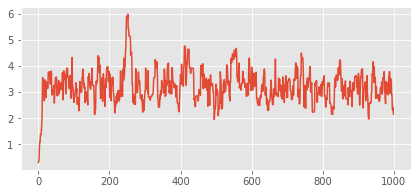

In [43]:
## the chain takes some iterations to converge to a steady state
## usually much longer for more realistic problems
## this is known as burn in
fig = plt.figure()
ax = plt.axes()
plt.plot(np.arange(1000), chain[:1000]);

In [44]:
## remove the first 1000 iterations to get rid of burn in
## could remove less, but we usually try to be conservative
chain = chain[1000:]

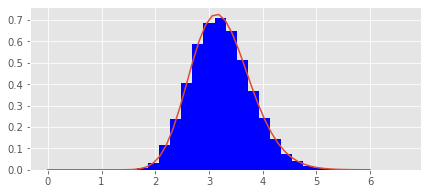

In [45]:
fig = plt.figure()
ax = plt.axes()
ns, bins, rectangles = ax.hist(chain,25,density=True,color='blue')
p = np.linspace(.5,.85,100);
lbda = np.linspace(0,6)
plt.plot(lbda, scipy.stats.gamma.pdf(lbda,a=post_alpha,scale=1/post_beta));

##### The posterior computed with metropolis looks very similar to the posterior computed using the conjugate result.

In [46]:
chain_s = np.sort(chain)
ixL = np.floor(np.size(chain_s)*.025).astype(int) ## lower index
ixU = np.floor(np.size(chain_s)*.975).astype(int) ## upper index

The lower and upper bound for a 95% credible interval is


In [47]:
print("The lower bound for a 95% credible interval is:",chain_s[ixL], "\n","The upper bound for a 95% credible interval is:",chain_s[ixU])

The lower bound for a 95% credible interval is: 2.237976528151623 
 The upper bound for a 95% credible interval is: 4.411854040700971


In [48]:
print("verifying whether they are same are not:")
lhs = scipy.stats.gamma.ppf(0.025, a=post_alpha, scale=1/post_beta)
rhs = scipy.stats.gamma.ppf(0.975, a=post_alpha, scale=1/post_beta)
print("lhs:",lhs)
print("rhs:",rhs)

verifying whether they are same are not:
lhs: 2.242475084244978
rhs: 4.4137399303970755


#### Posterior mean from conjugacy and Metropolis are very close as well

In [34]:
np.mean(chain)

3.2426788453680513

In [35]:
post_alpha / post_beta

3.238095238095238

In [51]:
print("The posterior mean from conjugacy (",post_alpha / post_beta,") and Metropolis mean (",np.mean(chain), ")are very close as well which is")

The posterior mean from conjugacy ( 3.238095238095238 ) and Metropolis mean ( 3.235751580876284 )are very close as well which is


## Problem 4 (Extra Credit)

### Setup

We use Stan to draw posterior samples for the infamous 8 schools example given in BDA by Gelman et al. (see p.119-p.124 in BDA for additional background). 

The 8 schools example looks at the SAT results in eight different schools which each had their own coaching program. The observation $y_j$ from school $j$ is a summary of the mean improvement in SAT score for that school relative to the intended national mean of about 500 (after some covariate adjustments), higher values are better. The hierarchical model for the full dataset is

$$ y_j \sim N(\theta_j,\sigma^2_j)\\\theta_j\sim N(\mu,\tau^2)\\\pi(\mu) \propto 1\\\pi(\tau) \propto 1, \tau>0$$

for $$j=1,\dots,J$$, where $$J=8$$. In this example the $$\sigma_j^2$$ are treated as known (because the number of pupils in each school were sufficiently large to estimate them precisely). 

### Task 

Use RStan or PyStan to obtain posterior samples of the unknown parameters $$\mu,\tau,\theta_1,\dots,\theta_J$$. You should make sure to:
- Provide a table and plots to summarize the posterior inference
- Comment on the convergence of the Markov chains.

You can follow one of these tutorials:
1. https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started#how-to-use-rstan
2. https://pystan.readthedocs.io/en/latest/getting_started.html

Note that the Stan code presented in the tutorials introduces additional parameters $\eta_j$ but these are simply for coding / interpretation efficiency and the model is unchanged. Note PyStan and RStan can be installed through Anaconda. PyStan works easily in Anaconda in my experience. However, in the case of RStan you may find it easier to install and run it using RStudio rather than Anaconda, but you are free to do it either way.

In [36]:
#pip install pystan

In [54]:
import pystan

In [55]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

The 8 schools example looks at the SAT results in eight different schools which each had their own coaching program. The observation $y_j$ from school $j$ is a summary of the mean improvement in SAT score for that school relative to the intended national mean of about 500 (after some covariate adjustments), higher values are better. The hierarchical model for the full dataset is

$$ y_j \sim N(\theta_j,\sigma^2_j)\\\theta_j\sim N(\mu,\tau^2)\\\pi(\mu) \propto 1\\\pi(\tau) \propto 1, \tau>0$$

for $j=1,\dots,J$, where $J=8$. In this example the $\sigma_j^2$ are treated as known (because the number of pupils in each school were sufficiently large to estimate them precisely). 

In [56]:
schools_code = """
data {
    int<lower=0> J; // number of schools
    vector[J] y; // estimated treatment effects
    vector<lower=0>[J] sigma; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""

In [57]:
sm = pystan.StanModel(model_code=schools_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_19a09b474d1901f191444eaf8a6b8ce2 NOW.


In [58]:
schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

In [59]:
fit = sm.sampling(data=schools_dat, iter=1000, chains=4)

In [60]:
fit

Inference for Stan model: anon_model_19a09b474d1901f191444eaf8a6b8ce2.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         7.96    0.14   5.13  -1.98   4.57   8.02  11.33  17.97   1327    1.0
tau        6.27    0.18   5.34    0.3   2.38   4.86   8.74  20.47    915    1.0
eta[1]     0.41    0.02   0.97  -1.54  -0.26   0.45   1.05   2.34   2310    1.0
eta[2]     0.03    0.02   0.86   -1.6  -0.53   0.01    0.6    1.8   2047    1.0
eta[3]    -0.21    0.02   0.95  -2.09  -0.82  -0.23    0.4   1.71   2744    1.0
eta[4]    -0.02    0.02   0.95  -1.91  -0.66 4.2e-3   0.58    1.9   2553    1.0
eta[5]    -0.34    0.02   0.92   -2.1  -0.95  -0.35   0.27   1.44   2033    1.0
eta[6]     -0.2    0.02   0.92  -1.89  -0.82   -0.2   0.41   1.59   2228    1.0
eta[7]     0.36    0.02   0.92  -1.53  -0.18   0.39   0.94    2.1   2060    1.0
eta[8]     0.

In [61]:
fit.get_posterior_mean()

array([[ 7.89580684e+00,  7.89371847e+00,  8.06279671e+00,
         7.97360808e+00],
       [ 6.67099926e+00,  6.55451748e+00,  5.41029826e+00,
         6.43724803e+00],
       [ 4.78660433e-01,  4.82177135e-01,  2.77169221e-01,
         4.17783716e-01],
       [ 3.18125634e-02,  7.66223244e-02,  3.87969507e-03,
         1.17353880e-03],
       [-2.29123604e-01, -2.15862694e-01, -1.97362039e-01,
        -2.00083475e-01],
       [ 8.59063812e-03, -5.75623544e-02, -5.25619148e-02,
         3.74141323e-03],
       [-3.54937882e-01, -3.44417586e-01, -3.06128692e-01,
        -3.60923755e-01],
       [-2.26573440e-01, -1.92379370e-01, -1.54983098e-01,
        -2.27892008e-01],
       [ 3.33734227e-01,  3.96092233e-01,  3.71072112e-01,
         3.52988109e-01],
       [ 9.43346689e-02,  4.27476744e-02,  1.14603992e-02,
         1.15176545e-01],
       [ 1.17902524e+01,  1.21134763e+01,  1.05390100e+01,
         1.14660675e+01],
       [ 7.86014573e+00,  8.12443878e+00,  8.06431244e+00,
      

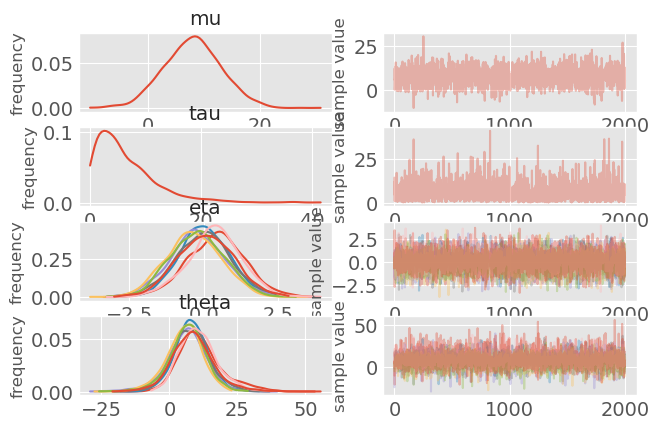

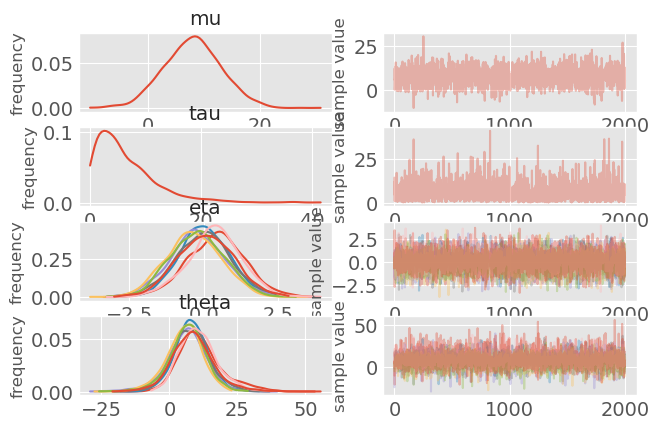

In [62]:
fit.plot()

In [63]:
#pip install arviz

In [64]:
import arviz as az
import numpy as np

# ArviZ ships with style sheets!
az.style.use('arviz-darkgrid')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021265C08108>,
      dtype=object)

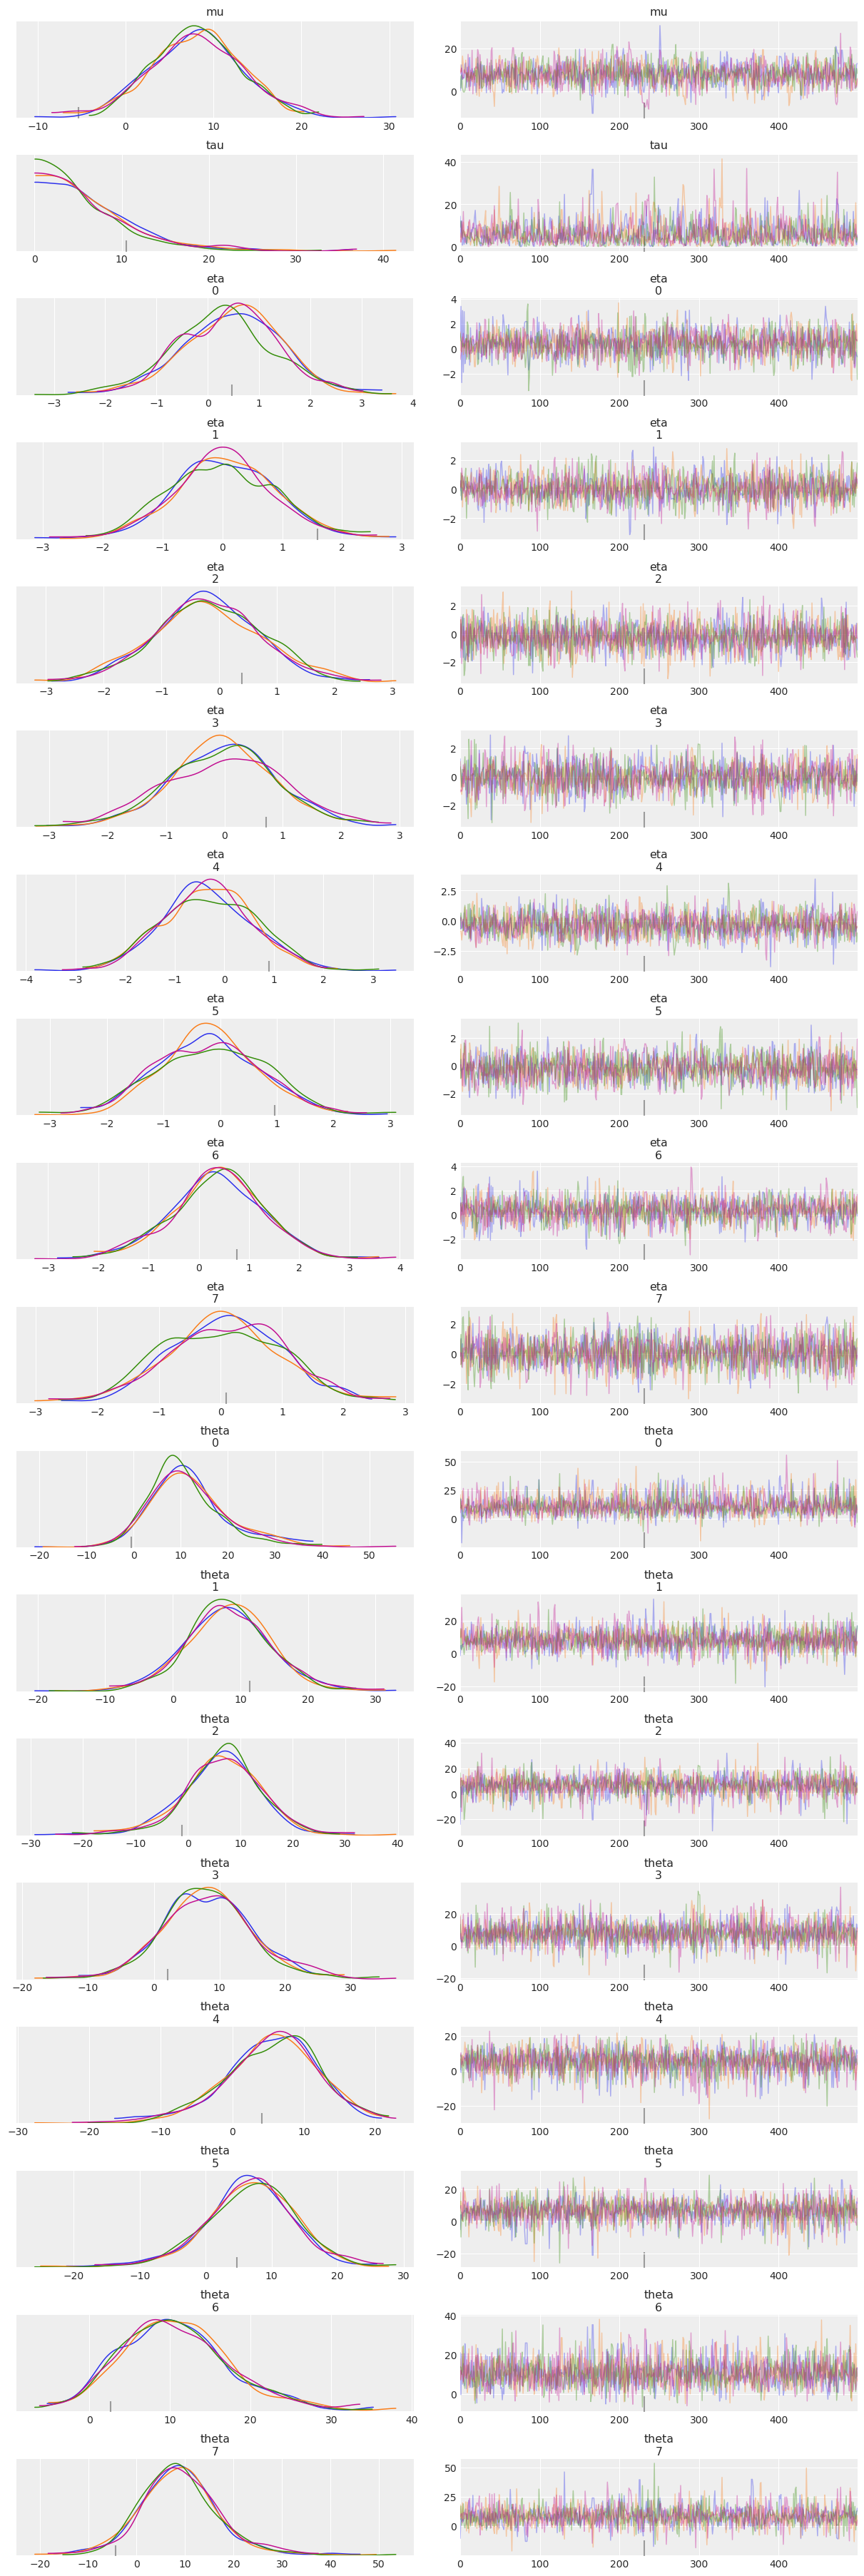

In [65]:
az.plot_trace(fit)